<div class="head0">
    <div class="head0__name">
        Various modules
    </div>
    <div class="head0__note">
        Examples for various modules from fpcross.
    </div>
</div>

In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from fpcross import ij

ij()

Start |  4:12PM MSK on Oct 09, 2019 |
-------------------------------------


<div class="head1">
    <div class="head1__name">
        Custom ODE solvers
    </div>
    <div class="head1__note">
        Solution of the ordinary differential equation (ODE) with multiple initial conditions by standard Euiler and the 4th order Runge-Kutta method.
    </div>
</div>

In [2]:
from fpcross import config, Grid, OrdSolver

In [3]:
names = ['eul', 'rk4', 'ivp']

l1 = config['opts']['plot']['line']['l1'].copy()
l1['label'] = names[0]
l2 = config['opts']['plot']['line']['l2'].copy()
l2['label'] = names[1]
l3 = config['opts']['plot']['line']['l3'].copy()
l3['label'] = names[2]
l4 = config['opts']['plot']['line']['l4'].copy()
l4['label'] = 'Appr'
l5 = config['opts']['plot']['line']['l5'].copy()
l5['label'] = 'Appr'

<div class="head1">
    <div class="head1__name">
        Test 1D
    </div>
</div>

Consider
$$
    d r = f(r, t) \, d t,
    \quad
    r \in R^{1},
    \quad
    r(0) = r_0,
    \quad
    f(r, t) = r^2,
$$
with known analytic solution
$$
    r(t) = \frac{r_0}{1 - r_0 t}.
$$

In [4]:
def func_f0(r, t):
    return r*r

def func_rt(t):
    return r0 / (1. - r0 * t)

TG = Grid(1, 2, [0., 0.0001], kind='u')
r0 = -2.5 * np.arange(1000).reshape(1, -1) + 0.2
r_real = func_rt(TG.l0[1])

In [5]:
for name in names:
    _t = time.time()

    SL = OrdSolver(TG, name)
    SL.init(func_f0)
    r_calc = SL.comp(r0)
    
    _e = np.mean(np.abs((r_real - r_calc) / r_real))

    print('Solver: "%s" | Err: %-8.2e | Time: %-8.2e'%(name, _e, time.time() - _t))

Solver: "eul" | Err: 2.08e-02 | Time: 3.62e-04
Solver: "rk4" | Err: 3.29e-06 | Time: 2.82e-04
Solver: "ivp" | Err: 1.39e-06 | Time: 3.10e-01


In [6]:
T_max = np.array([1E-6, 1E-5, 1E-4, 1E-3, 1E-2])
T_rk4, E_rk4 = [], []
T_eul, E_eul = [], []
T_ivp, E_ivp = [], []

for name in names:
    for t_max in T_max:
        _t = time.time()
        
        TG = Grid(1, 2, [0., t_max], kind='u')
        SL = OrdSolver(TG, name)
        SL.init(func_f0)
        r_calc = SL.comp(r0)

        _r = func_rt(t_max)
        _e = np.mean(np.abs((_r - r_calc) / _r))
        eval('T_' + name).append(time.time() - _t)
        eval('E_' + name).append(_e)

In [7]:
print('--- Convergence orders')

x = T_max[:-1]
y = np.array(E_eul[:-1])
a, b = np.polyfit(x**2, y, 1)
print('eul : %-8.1e h^2 + %-8.1e'%(a, b))

x = T_max[:-1]
y = np.array(E_rk4[:-1])
a, b = np.polyfit(x**5, y, 1)
print('rk4 : %-8.1e h^5 + %-8.1e'%(a, b))

--- Convergence orders
eul : 2.1e+06  h^2 + 1.1e-16 
rk4 : 8.4e+14  h^5 + -1.7e-06


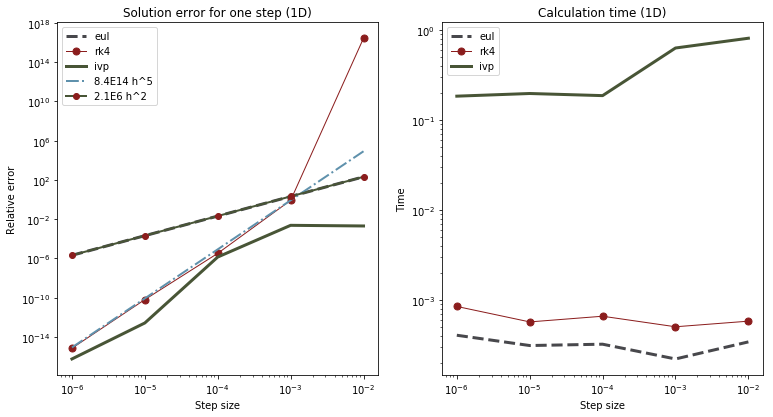

In [8]:
fig = plt.figure(**config['opts']['plot']['fig']['base_1_2'])
grd = mpl.gridspec.GridSpec(**config['opts']['plot']['grid']['base_1_2'])

ax1 = fig.add_subplot(grd[0, 0])
ax2 = fig.add_subplot(grd[0, 1])
ax1.plot(T_max, E_eul, **l1)
ax1.plot(T_max, E_rk4, **l2)
ax1.plot(T_max, E_ivp, **l3)

E_app = 8.4e+14 * T_max**5
l4['label'] = '8.4E14 h^5'
ax1.plot(T_max, E_app, **l4)

E_app = 2.1E+06 * T_max**2
l5['label'] = '2.1E6 h^2'
ax1.plot(T_max, E_app, **l5)

ax1.set_title('Solution error for one step (1D)')
ax1.set_xlabel('Step size')
ax1.set_ylabel('Relative error')
ax1.legend(loc='best')
ax1.semilogx()
ax1.semilogy()

ax2.plot(T_max, T_eul, **l1)
ax2.plot(T_max, T_rk4, **l2)
ax2.plot(T_max, T_ivp, **l3)
ax2.set_title('Calculation time (1D)')
ax2.set_xlabel('Step size')
ax2.set_ylabel('Time')
ax2.legend(loc='best')
ax2.semilogx()
ax2.semilogy()

plt.show()

<div class="head1">
    <div class="head1__name">
        Test 2D
    </div>
</div>

Consider
$$
    d r = f(r, t) \, d t,
    \quad
    r = (r_1, r_2) \in R^{2},
    \quad
    r(0) = r_0.
$$

Let set analytic solution
$$
    r_1(t) = \sin{2 t^2} + r_{0, 1},
    \quad
    r_2(t) = \cos{2 t^2} + r_{0, 2} - 1,
$$
then for the rhs we have
$$
    f_1(r, t) = 4 t \cos{2 t^2} = 4 t (r_2 - r_{0, 2} + 1),
    \quad
    f_2(r, t) = - 4 t \sin{2 t^2} = - 4 t (r_1 - r_{0, 1}).
$$

In [9]:
def func_f0(r, t, r0):
    v1 = +4. * t * (r[1, :] - r0[1, :] + 1.)
    v2 = -4. * t * (r[0, :] - r0[0, :])
    return np.vstack([v1, v2])

def func_rt(t):
    v1 = np.sin(2. * t * t) + r0[0, :]
    v2 = np.cos(2. * t * t) + r0[1, :] - 1.
    return np.vstack([v1, v2])

TG = Grid(1, 2, [0., 0.001], kind='u')
r0 = np.vstack([
    np.arange(100) * 1.1 + 0.2,
    np.arange(100) * 1.5 + 0.3,
])
r_real = func_rt(TG.l0[1])

In [10]:
for name in names:
    _t = time.time()

    SL = OrdSolver(TG, name)
    SL.init(func_f0, with_y0=True)
    r_calc = SL.comp(r0)
    
    _e = np.mean(np.abs((r_real - r_calc) / r_real))

    print('Solver: "%s" | Err: %-8.2e | Time: %-8.2e'%(name, _e, time.time() - _t))

Solver: "eul" | Err: 9.47e-08 | Time: 2.82e-04
Solver: "rk4" | Err: 2.98e-18 | Time: 5.97e-04
Solver: "ivp" | Err: 1.45e-17 | Time: 1.03e-01


In [11]:
T_max = np.array([1E-6, 1E-5, 1E-4, 1E-3, 1E-2, 1E-1])
T_rk4, E_rk4 = [], []
T_eul, E_eul = [], []
T_ivp, E_ivp = [], []

for name in names:
    for t_max in T_max:
        _t = time.time()
        
        TG = Grid(1, 2, [0., t_max], kind='u')
        SL = OrdSolver(TG, name)
        SL.init(func_f0, with_y0=True)
        r_calc = SL.comp(r0)

        _r = func_rt(t_max)
        _e = np.mean(np.abs((_r - r_calc) / _r))
        eval('T_' + name).append(time.time() - _t)
        eval('E_' + name).append(_e)

In [12]:
print('--- Convergence orders')

x = T_max[:-1]
y = np.array(E_eul[:-1])
a, b = np.polyfit(x**2, y, 1)
print('eul : %-8.1e h^2 + %-8.1e'%(a, b))

x = T_max[:-1]
y = np.array(E_rk4[:-1])
a, b = np.polyfit(x**5, y, 1)
print('rk4 : %-8.1e h^5 + %-8.1e'%(a, b))

--- Convergence orders
eul : 9.5e-02  h^2 + 1.1e-11 
rk4 : 9.3e-08  h^5 + 3.0e-18 


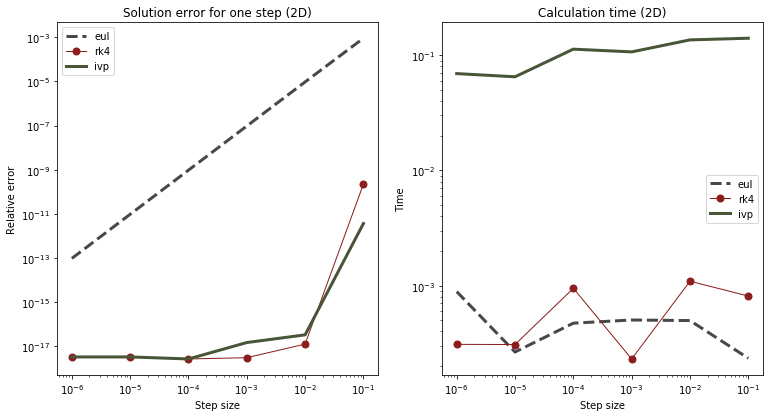

In [13]:
fig = plt.figure(**config['opts']['plot']['fig']['base_1_2'])
grd = mpl.gridspec.GridSpec(**config['opts']['plot']['grid']['base_1_2'])

ax1 = fig.add_subplot(grd[0, 0])
ax2 = fig.add_subplot(grd[0, 1])
ax1.plot(T_max, E_eul, **l1)
ax1.plot(T_max, E_rk4, **l2)
ax1.plot(T_max, E_ivp, **l3)

ax1.set_title('Solution error for one step (2D)')
ax1.set_xlabel('Step size')
ax1.set_ylabel('Relative error')
ax1.legend(loc='best')
ax1.semilogx()
ax1.semilogy()

ax2.plot(T_max, T_eul, **l1)
ax2.plot(T_max, T_rk4, **l2)
ax2.plot(T_max, T_ivp, **l3)
ax2.set_title('Calculation time (2D)')
ax2.set_xlabel('Step size')
ax2.set_ylabel('Time')
ax2.legend(loc='best')
ax2.semilogx()
ax2.semilogy()

plt.show()

<div class="head1">
    <div class="head1__name">
        Chebyshev differentiation matrices
    </div>
</div>

In [6]:
from fpcross import dif_cheb, Grid

<div class="head2">
    <div class="head2__name">
        Check for the matrix items
    </div>
</div>

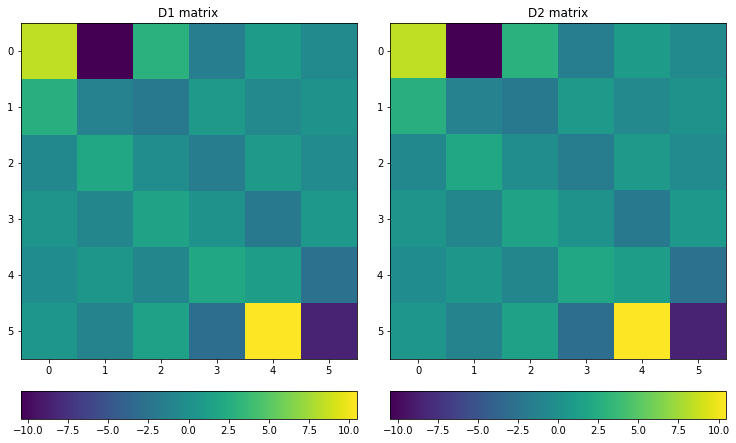

Error for D1 D1 = D2                       : 1.42e-14
Error for D1[0, 0] = (2N^2+1)/6            : 1.78e-15
Error for D1[0, 2] = + 2 / (1-x2)          : 0.00e+00
Error for D1[0, 3] = - 2 / (1-x3)          : 2.22e-16
Error for D1[4, 4] = - x[4] / 2 / (1-x4^2) : 6.66e-16


In [8]:
n = 6
N = n - 1
l = [-1., 1.]
SG = Grid(d=1, n=n, l=l)
D1, D2 = dif_cheb(n, 2, l[0], l[1])

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.1, hspace=0.02, width_ratios=[1, 1], height_ratios=[14, 1]
)

ax = fig.add_subplot(gs[0, 0])
ax.set_title('D1 matrix')
im = ax.imshow(D1)
ax = fig.add_subplot(gs[1, 0])
cb = plt.colorbar(im, cax=ax, orientation='horizontal')

ax = fig.add_subplot(gs[0, 1])
ax.set_title('D2 matrix')
im = ax.imshow(D1)
ax = fig.add_subplot(gs[1, 1])
cb = plt.colorbar(im, cax=ax, orientation='horizontal')

plt.show()

x = SG.comp()[0, :]

e = np.max(np.abs(D1@D1 - D2))
print('Error for D1 D1 = D2                       : %-8.2e'%np.max(np.abs(e)))

e = D1[0, 0] - (2.*N**2+1.) / 6.
print('Error for D1[0, 0] = (2N^2+1)/6            : %-8.2e'%np.max(np.abs(e)))

e = D1[0, 2] - 2. / (1. - x[2])
print('Error for D1[0, 2] = + 2 / (1-x2)          : %-8.2e'%np.max(np.abs(e)))

e = D1[0, 3] + 2. / (1. - x[3])
print('Error for D1[0, 3] = - 2 / (1-x3)          : %-8.2e'%np.max(np.abs(e)))

e = D1[4, 4] + x[4] / (1. - x[4]**2) / 2.
print('Error for D1[4, 4] = - x[4] / 2 / (1-x4^2) : %-8.2e'%np.max(np.abs(e)))

<div class="head0">
    <div class="head0__name">
        DRAFT below
    </div>
</div>

<div class="head1">
    <div class="head1__name">
        1D PDE solution by Chebyshev differentiation matrix
    </div>
</div>

Consider a model PDE

$$
\Delta u(x) = f(x),
\quad
x \in [0, 4],
\quad
u(0) = 0,
\quad
u(4) = 0,
\quad
f(x) = -\pi^2 \sin{(\pi x)},
$$
with known exact solution
$$
u(x) = \sin{(\pi x)}.
$$

We can solve it on the Chebyshev grid using 2th order Chebyshev differentiation matrix from the system
$$
D u = f,
$$
excluding boundary points.

<div class="head2">
    <div class="head2__name">
        Direct solution
    </div>
</div>

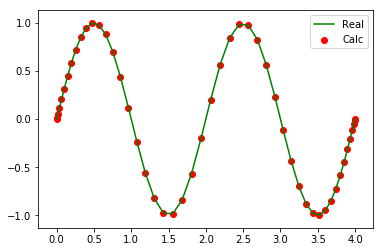

Number of spatial points :       50
Error                    : 9.16e-15    


In [14]:
def func_u(x):
    return np.sin(np.pi*x)

def func_f(x):
    return -1. * np.pi * np.pi * np.sin(np.pi*x)

IT = Intertrain(n=[50], l=[[0., 4.]])

X = IT.grid()
I = np.eye(IT.n[0])
J = np.eye(IT.n[0]); J[0, 0] = 0.; J[-1, -1] = 0.
D = J @ IT.dif2() + I - J
f = J @ (func_f(X).reshape(-1, 1))

u_calc = np.linalg.solve(D, f).reshape(-1)
u_real = func_u(X).reshape(-1)
e = np.linalg.norm(u_real-u_calc) / np.linalg.norm(u_real)
x = X.reshape(-1)

plt.plot(x, u_real, c='g', label='Real')
plt.scatter(x, u_calc, c='r', label='Calc')
plt.legend(loc='best')
plt.show()

print('Number of spatial points : %8d'%IT.n[0])
print('Error                    : %-12.2e'%e)

<div class="head2">
    <div class="head2__name">
        Time and convergence rates
    </div>
</div>

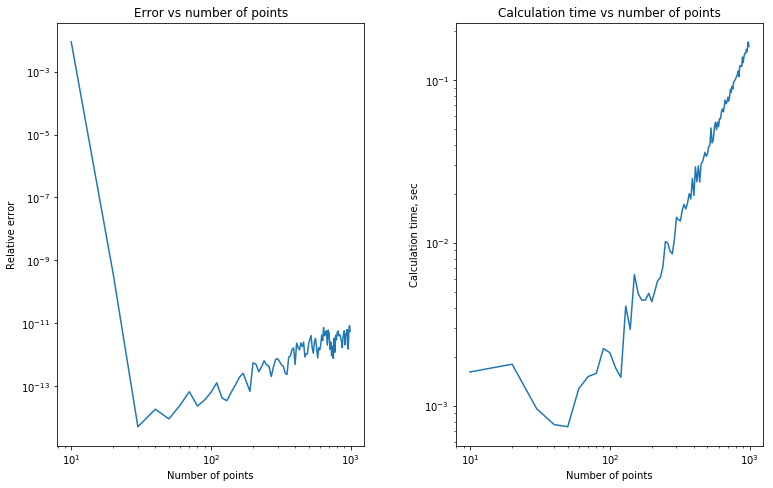

In [15]:
N = np.arange(10, 1000, 10)
T = []
E = []

for n in N:
    t = time.time()
    
    IT = Intertrain(n=[n], l=[[0., 4.]])

    X = IT.grid()
    I = np.eye(IT.n[0])
    J = np.eye(IT.n[0]); J[0, 0] = 0.; J[-1, -1] = 0.
    D = J @ IT.dif2() + I - J
    f = J @ (func_f(X).reshape(-1, 1))

    u_calc = np.linalg.solve(D, f).reshape(-1)
    u_real = func_u(X).reshape(-1)
    e = np.linalg.norm(u_real-u_calc) / np.linalg.norm(u_real)

    E.append(e) 
    T.append(time.time() - t)
    

fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(N, E)
ax.set_title('Error vs number of points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Relative error')
ax.semilogx()
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.plot(N, T)
ax.set_title('Calculation time vs number of points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Calculation time, sec')
ax.semilogx()
ax.semilogy()

plt.show()

<div class="head1">
    <div class="head1__name">
        1D time dependent PDE solution by Chebyshev differentiation matrix
    </div>
</div>

Let consider a model PDE

$$
\frac{\partial \, u}{\partial \, t} = \Delta u(x)
\quad
x \in [-2, 1],
\quad
u(-2) = 0,
\quad
u(1) = 0,
\quad
u(x, 0) = \sin{(\pi x)},
$$
with known exact solution
$$
u(x, t) = \sin{(\pi x)} e^{-\pi^2t}.
$$

We can solve it for the time $t$ using uniform time grid with step $h$ and iterations
$$
u_{k+1}(x) = e^{h \cdot D_2} u_{k}(x),
\quad
k = 0, 1, \ldots, \frac{t}{h} - 1.
$$
where $u_{0}(x)$ is known initial condition.

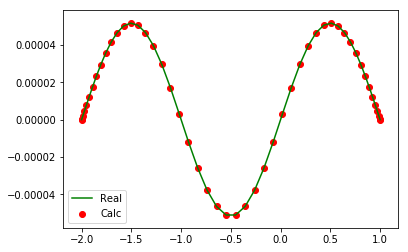

Number of time points    :    10000
Number of spatial points :       50
Error                    : 8.94e-10    


In [16]:
# Equation parameters

def func_u(x, t):
    return np.sin(np.pi*x) * np.exp(-1. * np.pi**2 * t)

def func_u0(x):
    return func_u(x, 0)

# Time grid

t_min = 0.
t_max = 1.
t_poi = 10000

m = t_poi
h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(t_min, t_max, t_poi)

# Spatial grid and Cheb. dif. matrix

n = 50

IT = Intertrain(n=[n], l=[[-2., 1.]])
X = IT.grid()
D = IT.dif2()

# Solution

J = np.eye(n); J[0, 0] = 0.; J[-1, -1] = 0.

Z = expm(h * J @ D)

u = func_u0(X).reshape(-1)
for t in T[:-1]:
    u = Z@u

# Check result
    
t = t_max
x = X.reshape(-1)
v = func_u(X, t).reshape(-1)
e = np.linalg.norm(v - u) / np.linalg.norm(v)

# Output result

plt.plot(x, v, c='g', label='Real')
plt.scatter(x, u, c='r', label='Calc')
plt.legend(loc='best')
plt.show()


print('Number of time points    : %8d'%t_poi)
print('Number of spatial points : %8d'%IT.n[0])
print('Error                    : %-12.2e'%e)

<div class="head2">
    <div class="head2__name">
        Time and convergence rates vs number of spatial points
    </div>
</div>

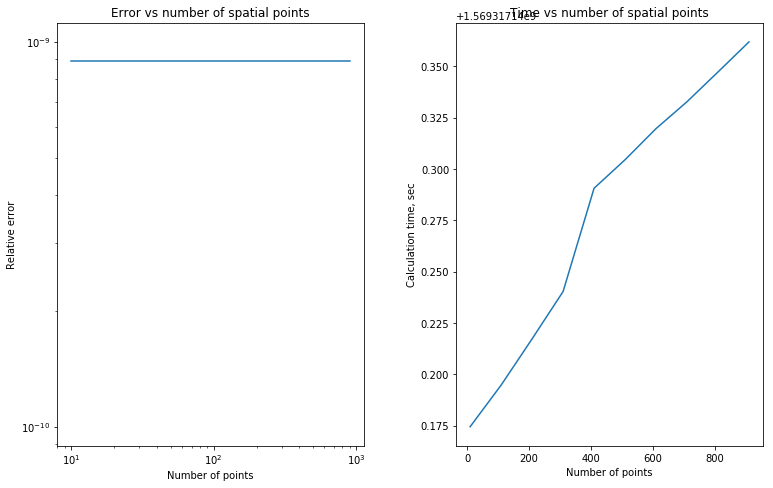

In [17]:
m = 10000
N = np.arange(10, 1000, 100)
Ts = []
Es = []

for n in N:
    t = time.time()

    t_min = 0.
    t_max = 1.
    t_poi = m

    h = (t_max - t_min) / (t_poi - 1)

    T = np.linspace(t_min, t_max, t_poi)

    n = 50

    IT = Intertrain(n=[n], l=[[-2., 1.]])
    X = IT.grid()
    D = IT.dif2()

    J = np.eye(n); J[0, 0] = 0.; J[-1, -1] = 0.

    Z = expm(h * J @ D)

    u = func_u0(X).reshape(-1)
    for t in T[:-1]:
        u = Z@u

    t = t_max
    x = X.reshape(-1)
    v = func_u(X, t).reshape(-1)
    e = np.linalg.norm(v - u) / np.linalg.norm(v)

    Es.append(e)
    Ts.append(time.time() - t)
    
fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(N, Es)
ax.set_title('Error vs number of spatial points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Relative error')
ax.semilogx()
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.plot(N, Ts)
ax.set_title('Time vs number of spatial points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Calculation time, sec')
#ax.semilogx()
#ax.semilogy()

plt.show()

<div class="head2">
    <div class="head2__name">
        Time and convergence rates vs number of time points
    </div>
</div>

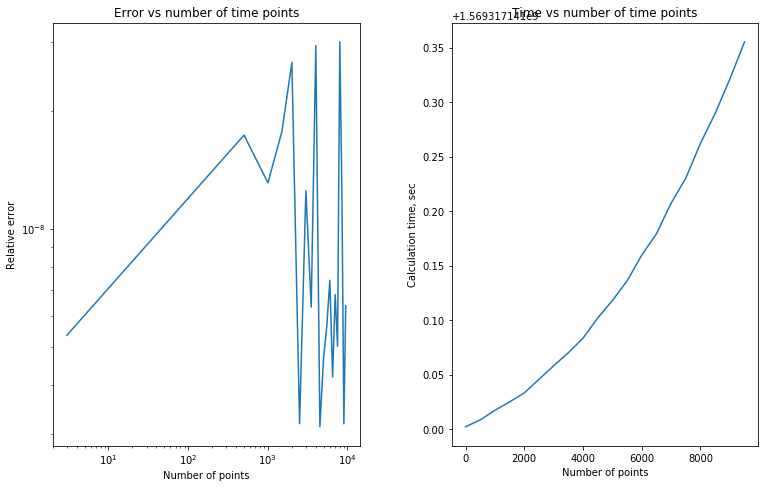

In [18]:
n = 100
M = np.arange(3, 10000, 500)
Ts = []
Es = []

for m in M:
    t = time.time()

    t_min = 0.
    t_max = 1.
    t_poi = m

    h = (t_max - t_min) / (t_poi - 1)

    T = np.linspace(t_min, t_max, t_poi)

    IT = Intertrain(n=[n], l=[[-1., 1.]])
    X = IT.grid()
    D = IT.dif2()

    J = np.eye(n); J[0, 0] = 0.; J[-1, -1] = 0.

    Z = expm(h * J @ D)

    u = func_u0(X).reshape(-1)
    for t in T[:-1]:
        u = Z@u

    t = t_max
    x = X.reshape(-1)
    v = func_u(X, t).reshape(-1)
    e = np.linalg.norm(v - u) / np.linalg.norm(v)

    Es.append(e)
    Ts.append(time.time() - t)

    
fig = plt.figure(figsize=(10, 6))
gs = mpl.gridspec.GridSpec(ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.3)

ax = fig.add_subplot(gs[0, 0])
ax.plot(M, Es)
ax.set_title('Error vs number of time points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Relative error')
ax.semilogx()
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.plot(M, Ts)
ax.set_title('Time vs number of time points')
ax.set_xlabel('Number of points')
ax.set_ylabel('Calculation time, sec')
#ax.semilogx()
#ax.semilogy()

plt.show()

<div class="end"></div>